In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import json
from pathlib import Path
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Appends the entire project folder to the path.
# This allows us to make a relative import of our scripts in brainstation_capstone/scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities import utils

# **0. Setting Up the Dataset and Cleaning Lyrics**
Author: Justin Ng

This notebook contains all the steps for converting lyrics into various representations. The specific steps will include the following:

- Loading the data from the original dataset. 
    - One table for lyrics.
    - One table that includes song info. 
    - Both are stored in a json format. 
- Rudimentary cleaning of the lyrics. 
- Detecting and selecting for english songs. 
- Exploring Genius page views. 

## Loading the Data

The first step is to load the original dataset from the following:

Expertise and Dynamics within Crowdsourced Musical Knowledge Curation: A Case Study of the Genius Platform.
<br>Derek Lim and Austin R. Benson.
<br>Proceedings of International Conference on Web and Social Media (ICWSM), 2021. 

Dataset found [here.](https://www.cs.cornell.edu/~arb/data/genius-expertise/)

The original dataset comes in two parts. `lyrics.jl` provides the lyric data and `song_info.json` provides further song info, such as primary artist. 

You can go into the `utils` module in `utilities` to get the details on how these files were parsed. 

In [4]:
# Set relative path for the raw data
DATA_PATH = utils.get_datapath('data')

In [5]:
# Load the lyrics.
lyrics_df = utils.json_loader(DATA_PATH / 'genius-expertise' / 'lyrics.jl')

In [6]:
display(lyrics_df.info())
display(lyrics_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37993 entries, 0 to 37992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   song    37993 non-null  object
 1   lyrics  37993 non-null  object
dtypes: object(2)
memory usage: 593.8+ KB


None

(37993, 2)

We can see that the dataset has 37993 lyrics. 

We will also load the song info. 

In [7]:
# Load the song info.
song_info_df = utils.json_loader(DATA_PATH / 'genius-expertise'/ 'song_info.json')

In [8]:
display(song_info_df.info())
display(song_info_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223257 entries, 0 to 223256
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   url_name        223257 non-null  object 
 1   title           223257 non-null  object 
 2   primary_artist  223257 non-null  object 
 3   release_date    176884 non-null  object 
 4   pyongs          223256 non-null  float64
 5   contributors    223257 non-null  int64  
 6   has_bio         223257 non-null  bool   
 7   views           72065 non-null   float64
 8   tags            223257 non-null  object 
 9   annotations     0 non-null       float64
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 15.5+ MB


None

(223257, 10)

In [9]:
song_info_df.head()

,url_name,title,primary_artist,release_date,pyongs,contributors,has_bio,views,tags,annotations
0,Kendrick-lamar-swimming-pools-drank-lyrics,Swimming Pools (Drank),Kendrick-lamar,"July 31, 2012",894.0,403,True,5589280.0,"[Trap, Conscious Hip-Hop, Memes, West Coast, R...",NaN
1,Kendrick-lamar-money-trees-lyrics,Money Trees,Kendrick-lamar,"October 22, 2012",880.0,394,True,4592003.0,"[Conscious Hip-Hop, West Coast, Rap, Producer]",NaN
2,Kendrick-lamar-xxx-lyrics,XXX.,Kendrick-lamar,"April 14, 2017",188.0,389,True,4651514.0,"[Conscious Hip-Hop, Boom Bap, Pop, West Coast,...",NaN
3,A-ap-rocky-fuckin-problems-lyrics,Fuckin’ Problems,A-ap-rocky,"October 24, 2012",706.0,437,True,7378309.0,"[Gangsta Rap, Dirty South, Atlanta, Posse Cut,...",NaN
4,Kendrick-lamar-dna-lyrics,DNA.,Kendrick-lamar,"April 14, 2017",555.0,570,True,5113687.0,"[Politics, Producer, News, Conscious Hip-Hop, ...",NaN


We can see that there is info on the various songs in the dataset. We are primarily interested in the `title`, `primary_artist`, `release_date` and `views`. 

From the above sample of the dataset we can see that the `release_date` is a string and we are going to only extract the year from the release_date. 

In [10]:
song_info_df.isna().mean()

url_name          0.000000
title             0.000000
primary_artist    0.000000
release_date      0.207711
pyongs            0.000004
contributors      0.000000
has_bio           0.000000
views             0.677211
tags              0.000000
annotations       1.000000
dtype: float64

We can see that we can drop the `annotations` as all the values are missing. This will make it easier to work with the dataset later on. Additionally, there are a lot of missing `views`, but we will only need the views for the 37 000 songs that we have lyrics for. 

In [11]:
song_info_df = song_info_df[
    song_info_df.columns.difference(['annotations'])
    ].dropna(axis=0)

# Analysis of Release Dates

In [12]:
def date_converter(date):
    '''
        This function is used to convert a release_date into just the year. 
    '''
 
    try:
        split_date = date.replace(',', '').split()
        if len(split_date) > 1:
            year = (int(split_date[2]))
        # If there is only the year. 
        elif len(split_date) == 1:
            year = (int(split_date[0]))
    except:
        year=(np.nan)

    return year

In [13]:
song_info_df['release_year'] = song_info_df.release_date.apply(date_converter)

In [14]:
song_info_df.head()

,contributors,has_bio,primary_artist,pyongs,release_date,tags,title,url_name,views,release_year
0,403,True,Kendrick-lamar,894.0,"July 31, 2012","[Trap, Conscious Hip-Hop, Memes, West Coast, R...",Swimming Pools (Drank),Kendrick-lamar-swimming-pools-drank-lyrics,5589280.0,2012.0
1,394,True,Kendrick-lamar,880.0,"October 22, 2012","[Conscious Hip-Hop, West Coast, Rap, Producer]",Money Trees,Kendrick-lamar-money-trees-lyrics,4592003.0,2012.0
2,389,True,Kendrick-lamar,188.0,"April 14, 2017","[Conscious Hip-Hop, Boom Bap, Pop, West Coast,...",XXX.,Kendrick-lamar-xxx-lyrics,4651514.0,2017.0
3,437,True,A-ap-rocky,706.0,"October 24, 2012","[Gangsta Rap, Dirty South, Atlanta, Posse Cut,...",Fuckin’ Problems,A-ap-rocky-fuckin-problems-lyrics,7378309.0,2012.0
4,570,True,Kendrick-lamar,555.0,"April 14, 2017","[Politics, Producer, News, Conscious Hip-Hop, ...",DNA.,Kendrick-lamar-dna-lyrics,5113687.0,2017.0


Now that we have successfully converted the release date into years, we will take a closer look at the release dates for the dataset. 

In [15]:
# Check to remove all nans for now, so that we can find the min and max of the release dates.
release_year_for_analysis = song_info_df.release_year[~np.isnan(song_info_df.release_year)]

In [16]:
release_year_for_analysis.min()

971.0

This is a strange year for the dataset. We will take a closer look at the release years. First we will try to output all the songs with a release year of `971`. 

In [17]:
for _, row in song_info_df.iterrows():
    if '971' in row['release_date']:
        print(row['title'])

Never Can Say Goodbye
Got to Be There
Echoes
Fearless
One of These Days
A Pillow of Winds
San Tropez
Seamus
Life on Mars?
Oh! You Pretty Things
Quicksand
Queen Bitch
The Bewlay Brothers
Andy Warhol
Kooks
Song for Bob Dylan
Fill Your Heart
Stairway to Heaven
Black Dog
Going to California
When the Levee Breaks
The Battle of Evermore
Rock and Roll
Misty Mountain Hop
Four Sticks
I Shall Be Released
You Ain’t Goin’ Nowhere
Tomorrow Is a Long Time
Too Many People
Uncle Albert/Admiral Halsey
Another Day
Monkberry Moon Delight
Dear Friend
Ram On
Dear Boy
Wild Horses
Brown Sugar
Dead Flowers
Can’t You Hear Me Knocking
Bitch
Sway
Moonlight Mile
I Got the Blues
Riders on the Storm
L.A. Woman
Love Her Madly
The WASP (Texas Radio and the Big Beat)
Been Down So Long
Hyacinth House
The Changeling
Cars Hiss by My Window
L’America
Crawling King Snake
Iron Man
Sweet Leaf
Children of the Grave
Solitude
Into the Void
After Forever
Lord of this World
Day After Day
It Don’t Come Easy
The Mothering Blackness

Seems like theres an error in the year value for songs released in 1971. We will make a new data_converter function and fix these values. 

In [18]:
def date_converter_updated(date):
    
    split_date = date.replace(',', '').split()
    if len(split_date) > 1:
        if '971' in split_date[-1]:
            year = (1971)
        else:
            year = (int(split_date[-1]))
    # If there is only the year. 
    elif len(split_date) == 1:
        if '971' in split_date[0]:
            year = (1971)
        else:
            year = (int(split_date[0]))

    return year
        
    


In [19]:
song_info_df['release_year'] = song_info_df.release_date.apply(date_converter_updated)

In [20]:
song_info_df.release_year.min(), song_info_df.release_year.max()

(1595, 2020)

In [21]:
for _, row in song_info_df.iterrows():
    if '1595' in row['release_date']:
        print(row['title'])

Romeo and Juliet Act 2 Scene 4


We see that we also have an excerpt of Romeo and Juliet in the dataset. 

# Combining Both Lyrics and Song Info

In [22]:
# Rename song column to merge on.
song_info_df.rename(
    {'url_name': 'song'},
    axis=1,
    inplace= True
)

# Merge the song views with the lyrics. 
raw_combined_df = pd.merge(
    lyrics_df, 
    song_info_df[['song', 'release_year', 'title', 'primary_artist', 'views']].dropna(axis=0),
    on='song',

)

In [23]:
# Raw uncleaned df.
display(raw_combined_df.head(10))
display(raw_combined_df.shape)
display(raw_combined_df.info())

,song,lyrics,release_year,title,primary_artist,views
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,2012,Swimming Pools (Drank),Kendrick-lamar,5589280.0
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,2012,Money Trees,Kendrick-lamar,4592003.0
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",2017,XXX.,Kendrick-lamar,4651514.0
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",2012,Fuckin’ Problems,A-ap-rocky,7378309.0
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",2017,DNA.,Kendrick-lamar,5113687.0
5,Kendrick-lamar-poetic-justice-lyrics,\n\n[Produced by Scoop DeVille & Sounwave]\n\n...,2012,Poetic Justice,Kendrick-lamar,4137688.0
6,Kendrick-lamar-bitch-dont-kill-my-vibe-lyrics,\n\n[Produced by Sounwave]\n\n[Chorus]\nI am a...,2012,"Bitch, Don’t Kill My Vibe",Kendrick-lamar,4455762.0
7,Kendrick-lamar-king-kunta-lyrics,\n\n[Produced by Sounwave; Additional producti...,2015,King Kunta,Kendrick-lamar,3976102.0
8,Kendrick-lamar-element-lyrics,\n\n[Intro: Kid Capri & Kendrick Lamar]\nNew K...,2017,ELEMENT.,Kendrick-lamar,2506800.0
9,Kendrick-lamar-the-blacker-the-berry-lyrics,\n\n[Produced by Boi-1da & Koz]\n\n[Intro: Ken...,2015,The Blacker the Berry,Kendrick-lamar,2557473.0


(35782, 6)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35782 entries, 0 to 35781
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   song            35782 non-null  object 
 1   lyrics          35782 non-null  object 
 2   release_year    35782 non-null  int64  
 3   title           35782 non-null  object 
 4   primary_artist  35782 non-null  object 
 5   views           35782 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 1.9+ MB


None

In [24]:
# Check for any duplicated songs
raw_combined_df.duplicated().mean()

0.0

In [25]:
raw_combined_df.release_year.min(), raw_combined_df.release_year.max()

(1962, 2020)

We have successfully combined the lyrics data with the song info data. Additionally, we checked that there are no duplicated songs. The release year range has also reduced considerably to 1962 to 2020. 

## Cleaning the Lyrics

This next step will deal with cleaning the punctuation and removing excess information from the lyrics. 

In [26]:
display(raw_combined_df.lyrics[0])

"\n\n[Produced by T-Minus]\n\n[Intro]\nPour up (Drank), head shot (Drank)\nSit down (Drank), stand up (Drank)\nPass out (Drank), wake up (Drank)\nFaded (Drank), faded (Drank)\n\n[Verse 1]\nNow I done grew up 'round some people livin' their life in bottles\nGranddaddy had the golden flask\nBackstroke every day in Chicago\nSome people like the way it feels\nSome people wanna kill their sorrows\nSome people wanna fit in with the popular, that was my problem\nI was in a dark room, loud tunes\nLookin' to make a vow soon\nThat I'ma get fucked up, fillin' up my cup I see the crowd mood\nChangin' by the minute and the record on repeat\nTook a sip, then another sip, then somebody said to me\n\n[Chorus]\nNigga, why you babysittin' only two or three shots?\nI'ma show you how to turn it up a notch\nFirst you get a swimming pool full of liquor, then you dive in it\nPool full of liquor, then you dive in it\nI wave a few bottles, then I watch 'em all flock\nAll the girls wanna play Baywatch\nI got a 

We can see that the raw lyrics contain multiple issues that could impede vectorization, namely:
- Punctuation
- `\n` delimiters 
- Tags for different parts of the lyrics. 

We will aim to eliminate all these issues. More detail can be found in the `utils` module. 

In [27]:
raw_combined_df['cleaned_lyrics'] = raw_combined_df['lyrics'].apply(utils.clean_lyrics)

In [28]:
display(raw_combined_df.head()),
raw_combined_df.shape

,song,lyrics,release_year,title,primary_artist,views,cleaned_lyrics
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,2012,Swimming Pools (Drank),Kendrick-lamar,5589280.0,pour up drank head shot drank sit down drank ...
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,2012,Money Trees,Kendrick-lamar,4592003.0,uh me and my niggas tryna get it ya bish ya b...
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",2017,XXX.,Kendrick-lamar,4651514.0,america god bless you if its good to you amer...
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",2012,Fuckin’ Problems,A-ap-rocky,7378309.0,i love bad bitches thats my fuckin problem an...
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",2017,DNA.,Kendrick-lamar,5113687.0,i got i got i got i got loyalty got royalty i...


(35782, 7)

We see that we have successfuuly converted the raw lyrics into `cleaned_lyrics`.

# Detecting Language

Our next step is to find only english songs to reduce the noise in the dataset introduced by songs that are not in english. We will use a pretrained Fasttext model trained for language detection. This is model performs faster than the Spacy language detection model. 
The Fasttext Language detection model found [here](https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin)

In [29]:

import fasttext

language = []
path_to_pretrained_model = utils.get_datapath('data') / 'language_detect' / 'lid.176.bin'


In [30]:
# Model for language detection.
fmodel = fasttext.load_model(str(path_to_pretrained_model))


In [31]:
language = []

for lyric in tqdm(raw_combined_df['cleaned_lyrics']):
    # fasttext model.predict returns a tuple of the language label and a score. 
    # The language label is another tuple, where the 0 index is the actual language label itself.
    # This label is in the format '__label__en'. So need to index the last two characters to get the actual language. 
    
    language.append(fmodel.predict(lyric)[0][0][-2:])
    


100%|██████████| 35782/35782 [00:04<00:00, 8535.81it/s]


In [32]:
# Number of unique languages
len(np.unique(np.array(language)))

26

In [33]:
# Assign language to the dataset.
raw_combined_df['language'] = language

In [34]:
english_songs_df = raw_combined_df[
    raw_combined_df['language'] == 'en'
]

In [35]:
display(english_songs_df.head())
display(english_songs_df.shape)

,song,lyrics,release_year,title,primary_artist,views,cleaned_lyrics,language
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,2012,Swimming Pools (Drank),Kendrick-lamar,5589280.0,pour up drank head shot drank sit down drank ...,en
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,2012,Money Trees,Kendrick-lamar,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",2017,XXX.,Kendrick-lamar,4651514.0,america god bless you if its good to you amer...,en
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",2012,Fuckin’ Problems,A-ap-rocky,7378309.0,i love bad bitches thats my fuckin problem an...,en
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",2017,DNA.,Kendrick-lamar,5113687.0,i got i got i got i got loyalty got royalty i...,en


(33842, 8)

# Exploring Views and Splitting Views

We will now take a look at the target, the page `views` on Genius.com. 

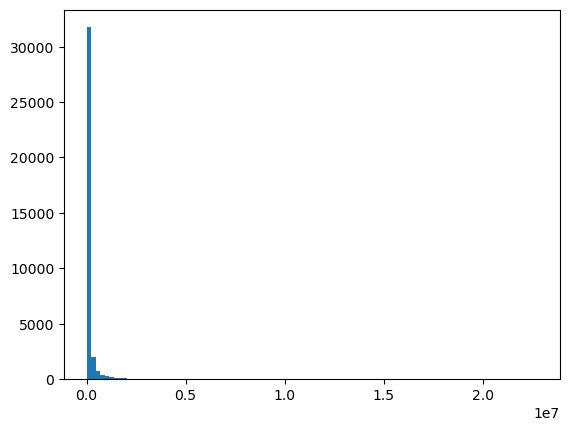

In [36]:
plt.hist(raw_combined_df['views'], bins=100);

We can see that there is a large right skew to the dataset. We can try to mitigate this by log-transforming the views.

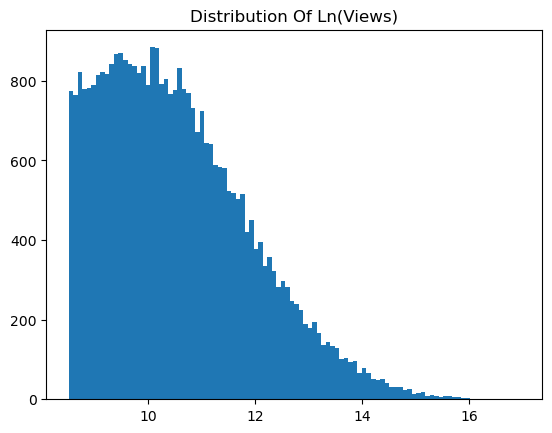

In [37]:
plt.figure()
plt.hist(np.log(raw_combined_df['views']), bins=100)
plt.title('Distribution of ln(views)'.title())
plt.show()

In [38]:
english_songs_df['log_scaled_views'] = np.log(raw_combined_df['views'])
english_songs_df.head()

/tmp/ipykernel_1141/1080093808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_songs_df['log_scaled_views'] = np.log(raw_combined_df['views'])


,song,lyrics,release_year,title,primary_artist,views,cleaned_lyrics,language,log_scaled_views
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,2012,Swimming Pools (Drank),Kendrick-lamar,5589280.0,pour up drank head shot drank sit down drank ...,en,15.536361
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,2012,Money Trees,Kendrick-lamar,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en,15.339827
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",2017,XXX.,Kendrick-lamar,4651514.0,america god bless you if its good to you amer...,en,15.352703
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",2012,Fuckin’ Problems,A-ap-rocky,7378309.0,i love bad bitches thats my fuckin problem an...,en,15.814055
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",2017,DNA.,Kendrick-lamar,5113687.0,i got i got i got i got loyalty got royalty i...,en,15.447431


Next we also binarize the log-transformed `views` to also allow for classification.

In [39]:
english_songs_df['popular'] = pd.cut(
    english_songs_df['log_scaled_views'], 
    bins = [0,english_songs_df['log_scaled_views'].median(), english_songs_df['log_scaled_views'].max()], 
    labels = [0,1]
    )

/tmp/ipykernel_1141/1843756530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_songs_df['popular'] = pd.cut(


In [40]:
english_songs_df['popular'].value_counts()

0    16921
1    16921
Name: popular, dtype: int64

Additionally, we turn this project into a multi-class problem by dividing the log-transformed views into thirds.

In [41]:
english_songs_df['popularity_three_class'] = pd.cut(
    english_songs_df['log_scaled_views'], 
    bins = [
        0,
        english_songs_df['log_scaled_views'].quantile(q=0.33), 
        english_songs_df['log_scaled_views'].quantile(q=0.66),
        english_songs_df['log_scaled_views'].max()
    ],
    labels=[0,1,2]
    )

/tmp/ipykernel_1141/3694795417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_songs_df['popularity_three_class'] = pd.cut(


In [42]:
english_songs_df['popularity_three_class'].value_counts()

2    11506
0    11168
1    11168
Name: popularity_three_class, dtype: int64

In [43]:
english_songs_df.head()

,song,lyrics,release_year,title,primary_artist,views,cleaned_lyrics,language,log_scaled_views,popular,popularity_three_class
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,2012,Swimming Pools (Drank),Kendrick-lamar,5589280.0,pour up drank head shot drank sit down drank ...,en,15.536361,1,2
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,2012,Money Trees,Kendrick-lamar,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en,15.339827,1,2
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",2017,XXX.,Kendrick-lamar,4651514.0,america god bless you if its good to you amer...,en,15.352703,1,2
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",2012,Fuckin’ Problems,A-ap-rocky,7378309.0,i love bad bitches thats my fuckin problem an...,en,15.814055,1,2
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",2017,DNA.,Kendrick-lamar,5113687.0,i got i got i got i got loyalty got royalty i...,en,15.447431,1,2


Here we have the complete dataset that we will work with for the first iteration of modeling. 

In [44]:
# Export the Dataset.
english_songs_df.to_csv(DATA_PATH / 'clean_lyrics_english.csv', index=False)

# Removing Stop Words and Stemming lyrics

One way to improve model performance is to utilize the removal of stop words and stemming the words. Specifically, we will use the english stop words found in `nltk` as well as the `SnowballStemmer` from the same package. This is a less aggressive stemmer that will hopefully perserve the words after stemming. 

In [45]:
english_songs_df = pd.read_csv(DATA_PATH / 'clean_lyrics_english.csv')

First we will remove all the stop words and stem every lyric. Further detail on the specfics of the function can be found in `utilities/utils.py`. 

In [46]:
# Initialize tqdm for pandas.
tqdm.pandas()

In [47]:
english_songs_df['cleaned_lyrics_stem'] = english_songs_df['cleaned_lyrics'].progress_apply(utils.stop_word_removal_and_stem) 

100%|██████████| 33842/33842 [00:38<00:00, 867.86it/s] 


In [48]:
# Check to see if there are any errors in the stemming process. 
english_songs_df['cleaned_lyrics_stem'].isna().mean()

0.0

Now that we have successfully removed all the stop words and stemmed the lyrics we can export this dataset.

In [49]:
# Export
english_songs_df.to_csv(DATA_PATH / 'clean_lyrics_english_stem.csv', index=False)

# Conclusion

This is the end of the preliminary setup of the dataset. The next step involves exploratory data analysis and can be found in  `notebooks/1_eda.ipynb`. 